In [1]:
from __future__ import print_function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml as fetch_mldata
from IPython.display import display, clear_output
from matplotlib import animation, rc
from IPython.display import HTML
from sklearn.decomposition import FactorAnalysis

%matplotlib inline
#%matplotlib notebook
    
def plot_im_array2(X,S,N,A,title):    
    I = np.ones(((A*(1+S),A*(1+S))))*max(X.flatten())
    k=0
    for i in range(A):
        for j in range(A):
            I[i*(S)+i:(i+1)*S+i,j*S+j:(j+1)*S+j] = X[k,:].reshape((S, S))
            k=k+1
            if(k==N): break
        if(k==N): break
            
    plt.imshow(I, cmap=plt.cm.gray,interpolation=None)
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    

Automatically created module for IPython interactive environment


## Load and display data

/Users/marlin/miniconda3/envs/689/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


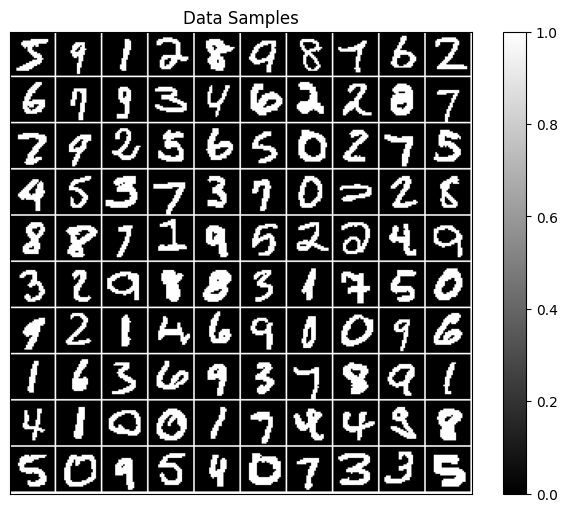

In [2]:
mnist = fetch_mldata('mnist_784')
X = mnist.data.to_numpy()
X = 1*(X>10)
plt.figure(figsize=[8,6]);
plot_im_array2(X[range(0,60000,600),:],28,100,10,"Data Samples")
plt.show()

Restricted Boltzmann Machine
===

In [3]:

def phgx(X,W,bH):
    pH = 1.0/(1+np.exp(X.dot(W) + bH))
    return pH

def pxgh(H,W,bX):
    pX = 1.0/(1+np.exp(H.dot(W.T) + bX))
    return pX

def rbm_reconstruct(X,W,bX,bH):
    N,D = X.shape
    D,K = W.shape
    H   = phgx(X,W,bH)
    PX  = pxgh(H,W,bX)
    return PX

def gibbs_step(X,W,bX,bH):
    N,D = X.shape
    D,K = W.shape
    H   = phgx(X,W,bH)>np.random.rand(N,K)
    PX  = pxgh(H,W,bX)
    X   = PX>np.random.rand(N,D)
    return X,PX

def grad(X,XS,W,bX,bH):
    N=X.shape[0]
    S=XS.shape[0]
    
    pH     = phgx(X,W,bH)
    posgW  = X.T.dot(pH)
    posgbH = np.sum(pH,axis=0,keepdims=True) 
    posgbX = np.sum(X,axis=0,keepdims=True)
    
    pH     = phgx(XS,W,bH)
    neggW  = XS.T.dot(pH)
    neggbH = np.sum(pH,axis=0,keepdims=True)
    neggbX = np.sum(XS,axis=0,keepdims=True)
    
    gradW  = posgW/N  - neggW/S
    gradbH = posgbH/N - neggbH/S
    gradbX = posgbX/N - neggbX/S
    return(gradW,gradbX,gradbH)
    
def learn(X, K = 100, S = 100, eps=0.01, lam=0.01, iters=10000):
    N,D = X.shape
    W  = np.random.randn(D,K)/10
    bH = np.random.randn(1,K)/10
    bX = np.random.randn(1,D)/10   
    
    XS = np.random.rand(S,D)>0.5
    
    for i in range(iters):

        XS,PXS = gibbs_step(XS,W,bX,bH)
        
        ind = np.random.randint(0,N,100)
        gradW,gradbX,gradbH = grad(X[ind,:],XS,W,bX,bH)
        W = W - eps*(gradW + lam*W)
        bX = bX - eps*(gradbX + lam*bX)
        bH = bH - eps*(gradbH + lam*bH)
        
        if(i%100==0):
            plt.figure(1,figsize=[20,7.5])
            #plt.clf()
            plt.subplot(1,2,1)
            plot_im_array2(W.T,28,100,10,"Weights (%d)"%i)
            plt.subplot(1,2,2)
            plot_im_array2(PXS,28,100,10,"Model Samples (%d)"%i)
            #plt.draw()
            clear_output(True)
            plt.show()
            
    return W,bX,bH
    

## Learn the model

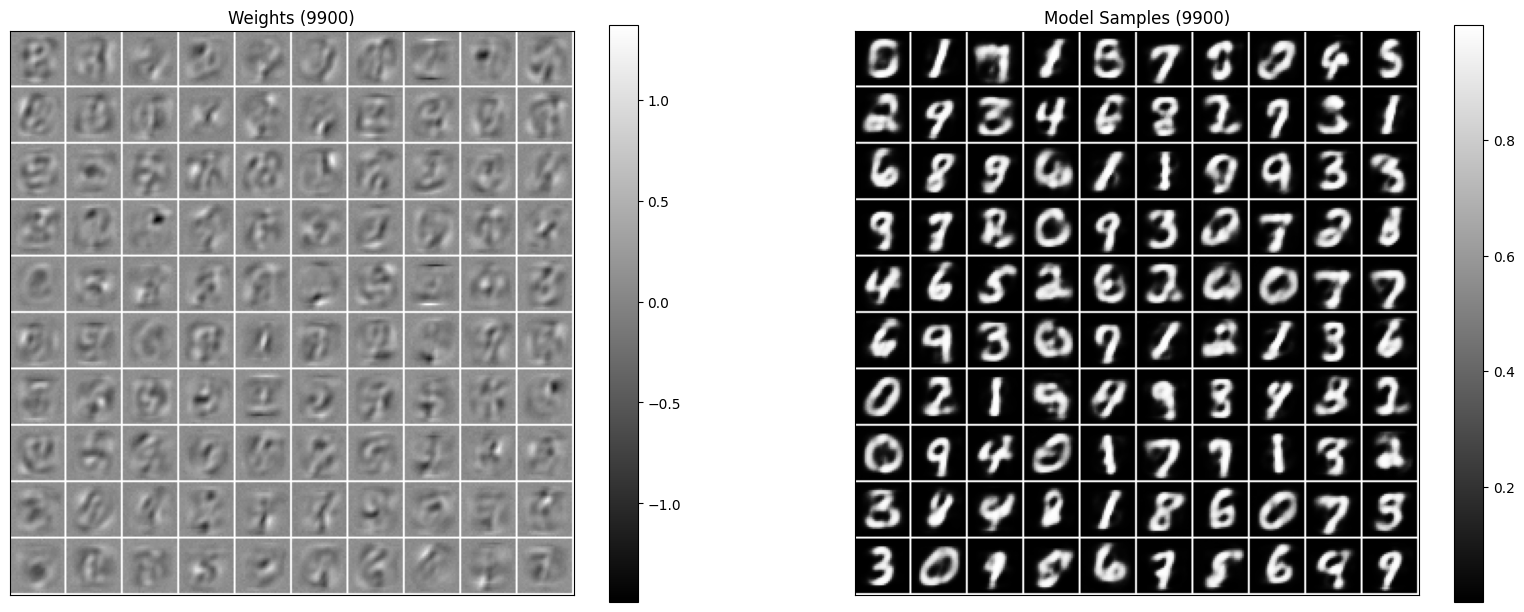

In [4]:
W,bX,bH = learn(X)

## De-Noising

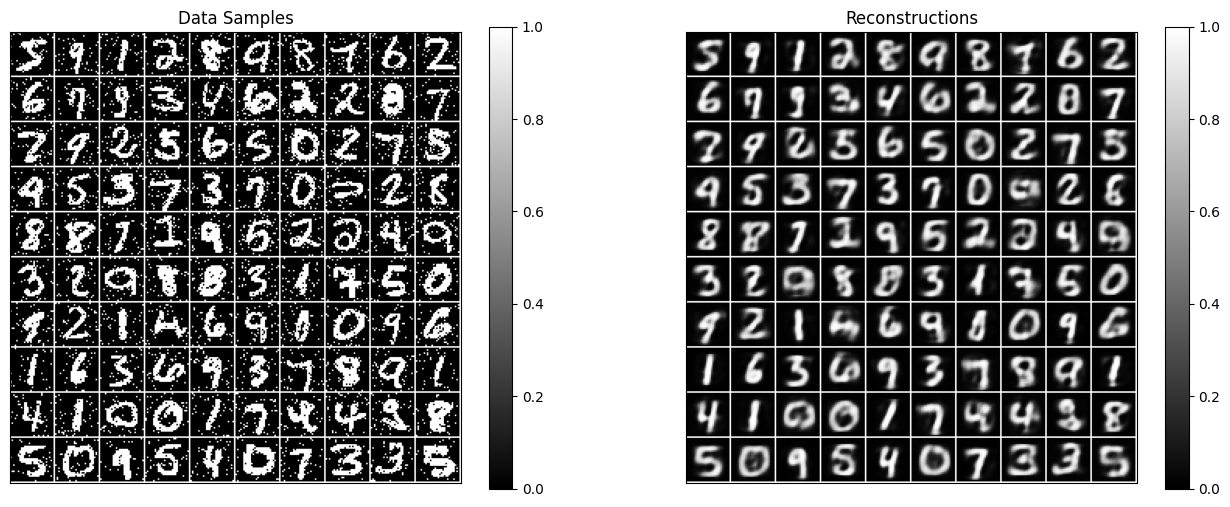

In [5]:
Xsub = X[range(0,60000,600),:]
noise = np.random.rand(*Xsub.shape)>0.95
Xsub = Xsub*(1-noise) + (1-Xsub)*noise 
XR=rbm_reconstruct(Xsub,W,bX,bH)

plt.figure(1,figsize=[16,6])
plt.subplot(1,2,1)
plot_im_array2(Xsub,28,100,10,"Data Samples")
plt.subplot(1,2,2)
plot_im_array2(XR,28,100,10,"Reconstructions")
plt.clim(0,1)

## Generation

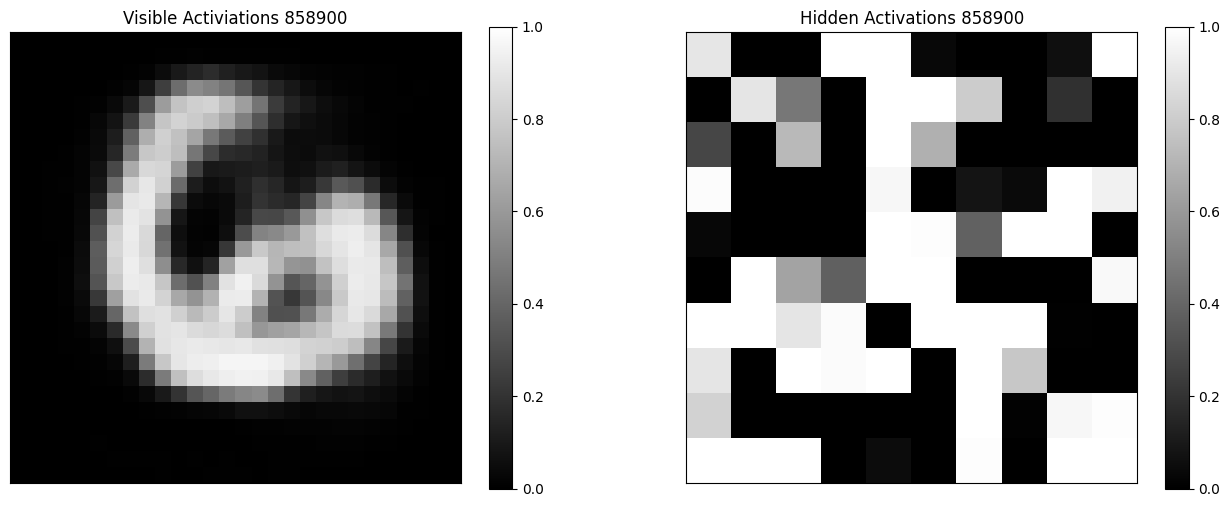

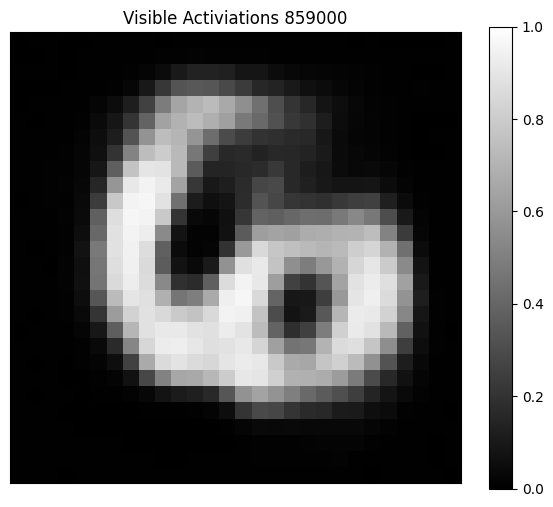

In [7]:
N,D = X.shape
H   = np.random.rand(1,100)>0.8
XS  = pxgh(H,W,bX)

i=0
try:
    while(True):
        XS,PXS=gibbs_step(XS,W,bX,bH)
        if(i%100==0):
            plt.figure(1,figsize=[16,6])
            plt.clf()
            plt.subplot(1,2,1)
            plt.imshow(PXS.reshape((28,28)), cmap=plt.cm.gray,interpolation=None)
            plt.clim(0,1)
            plt.colorbar()
            plt.xticks(())
            plt.yticks(())
            plt.title("Visible Activiations %d"%(i))
            
            plt.subplot(1,2,2)
            H = phgx(XS,W,bH)
            #plt.imshow(XS.reshape((28,28)), cmap=plt.cm.gray,interpolation=None)  
            plt.imshow(H.reshape((10,10)), cmap=plt.cm.gray,interpolation=None) 
            plt.clim(0,1)
            plt.colorbar()
            plt.xticks(())
            plt.yticks(())
            plt.title("Hidden Activations %d"%(i))
            
            plt.draw()
            clear_output(True)
            plt.show()        
        i=i+1
        
except:
        pass